In [1]:
import os 
import sys 
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')
# Pytorch module 
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torch.utils.tensorboard import SummaryWriter

import pytorch_lightning as pl

import random
from typing import Any, Mapping
from time import gmtime, strftime

# set working directory
os.chdir('/home/jovyan/contrails/contrails_detection/')

# Project Module
import config
import src.utils as utils
from src.dataset import ContrailsDataset, ContrailsDatasetSeqs
from src.model import BaseUnet, SegmentLightning, AttentionUNet, UNetPlus, SegmentLightningTS
from src.train import Trainer
from src.trainer_lgt import TrainerLightning

## Tensorboard Modules
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping

# Memory management
def clear_torch_cache():
    torch.cuda.empty_cache()
    print("Cleared PyTorch GPU cache.")

# Run the function to clear GPU cache
clear_torch_cache()

!nvidia-smi

Cleared PyTorch GPU cache.
Tue Sep  3 11:44:20 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.14              Driver Version: 550.54.14      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA RTX A4000               Off |   00000000:03:00.0 Off |                  Off |
| 41%   34C    P8              7W /  140W |       3MiB /  16376MiB |      0%      Default |
|                                         |                        |                  N/A |
+--------------------

In [2]:
## Load file from csv split into train/test
from sklearn.model_selection import train_test_split
test_df = pd.read_csv(config.CSV_VALID_REC, index_col=0)
test_df = test_df[test_df['Class'].isin([0, 1])]
test_df.head()

,Image_ID,Class
0,156612315464765843,1
1,1711045123448643132,1
2,1060255682366112357,1
3,1206753187405219040,0
4,1388604837578071066,0


In [3]:
## Data collection for single frame
torch.manual_seed(44)
transform = transforms.Compose([
    # Add your desired transformations here
    transforms.ToTensor(),
    transforms.Lambda(lambda x: utils.compute_TDi_ashrgb(x, -5)),
                      ])


sf_test_dataset = ContrailsDataset(dataframe=test_df,
                                 root_dir=config.DATA_DIR+'validation',
                                 transform=transform,
                                 sequence_index=config.TS # nth:5 sequence image
                                )

## Data Loaders
sf_test_dataloader = DataLoader(sf_test_dataset,
                              batch_size=4,
                              shuffle=True,
                              num_workers=config.WORKERS,
                              pin_memory=True,
                              prefetch_factor=config.WORKERS,
                             )
### Multiframe test data 

mf_transform = transforms.Compose([
    # Add your desired transformations here
    #transforms.ToTensor(),
    transforms.Lambda(lambda x: x/256.0),
    transforms.Lambda(utils.get_rgb),
                      ])


mf_test_dataset = ContrailsDatasetSeqs(dataframe=test_df,
                                 root_dir=config.DATA_DIR+'validation',
                                 transform=mf_transform,
                                )

## Data Loaders
mf_test_dataloader = DataLoader(mf_test_dataset,
                              batch_size=4,
                              shuffle=True,
                              num_workers=config.WORKERS,
                              pin_memory=True,
                              prefetch_factor=config.WORKERS,
                             )

In [4]:
sf_data, sf_targets = next(iter(sf_test_dataloader))
mf_data, mf_targets = next(iter(mf_test_dataloader))

sf_data.shape, sf_targets.shape, mf_data.shape, mf_targets.shape

(torch.Size([4, 5, 256, 256]),
 torch.Size([4, 1, 256, 256]),
 torch.Size([4, 3, 8, 256, 256]),
 torch.Size([4, 1, 256, 256]))

In [21]:
# Plot Batch Image and Mask 
def plot_image_and_mask_v(image_batch, mask_batch, pred_batch=None):
    batch_size = image_batch.shape[0]
    num_rows = 3 if pred_batch is None else 4

    fig, axes = plt.subplots(num_rows, batch_size, figsize=(4 * batch_size, 10))

    for i in range(batch_size):
        rgb_image = image_batch[i, 0:3, :, :].cpu().numpy().transpose((1, 2, 0))
        mask_band = mask_batch[i, 0, :, :].cpu().numpy()

        axes[0, i].imshow(rgb_image)
        axes[0, i].set_title(f"Image {i + 1}")

        axes[1, i].imshow(mask_band, interpolation="none")
        axes[1, i].set_title(f"Mask {i + 1}")

        overlay = np.zeros_like(rgb_image)
        overlay[mask_band > 0.5] = 1.0
        axes[2, i].imshow(rgb_image)
        axes[2, i].imshow(overlay, cmap="cividis", alpha=0.4, interpolation="none")
        axes[2, i].set_title(f"Overlay {i + 1}")

        if pred_batch is not None:
            pred_band = pred_batch[i, 0, :, :].cpu().numpy()
            axes[3, i].imshow(pred_band, interpolation="none")
            axes[3, i].set_title(f"Prediction {i + 1}")

    plt.tight_layout()
    plt.show()

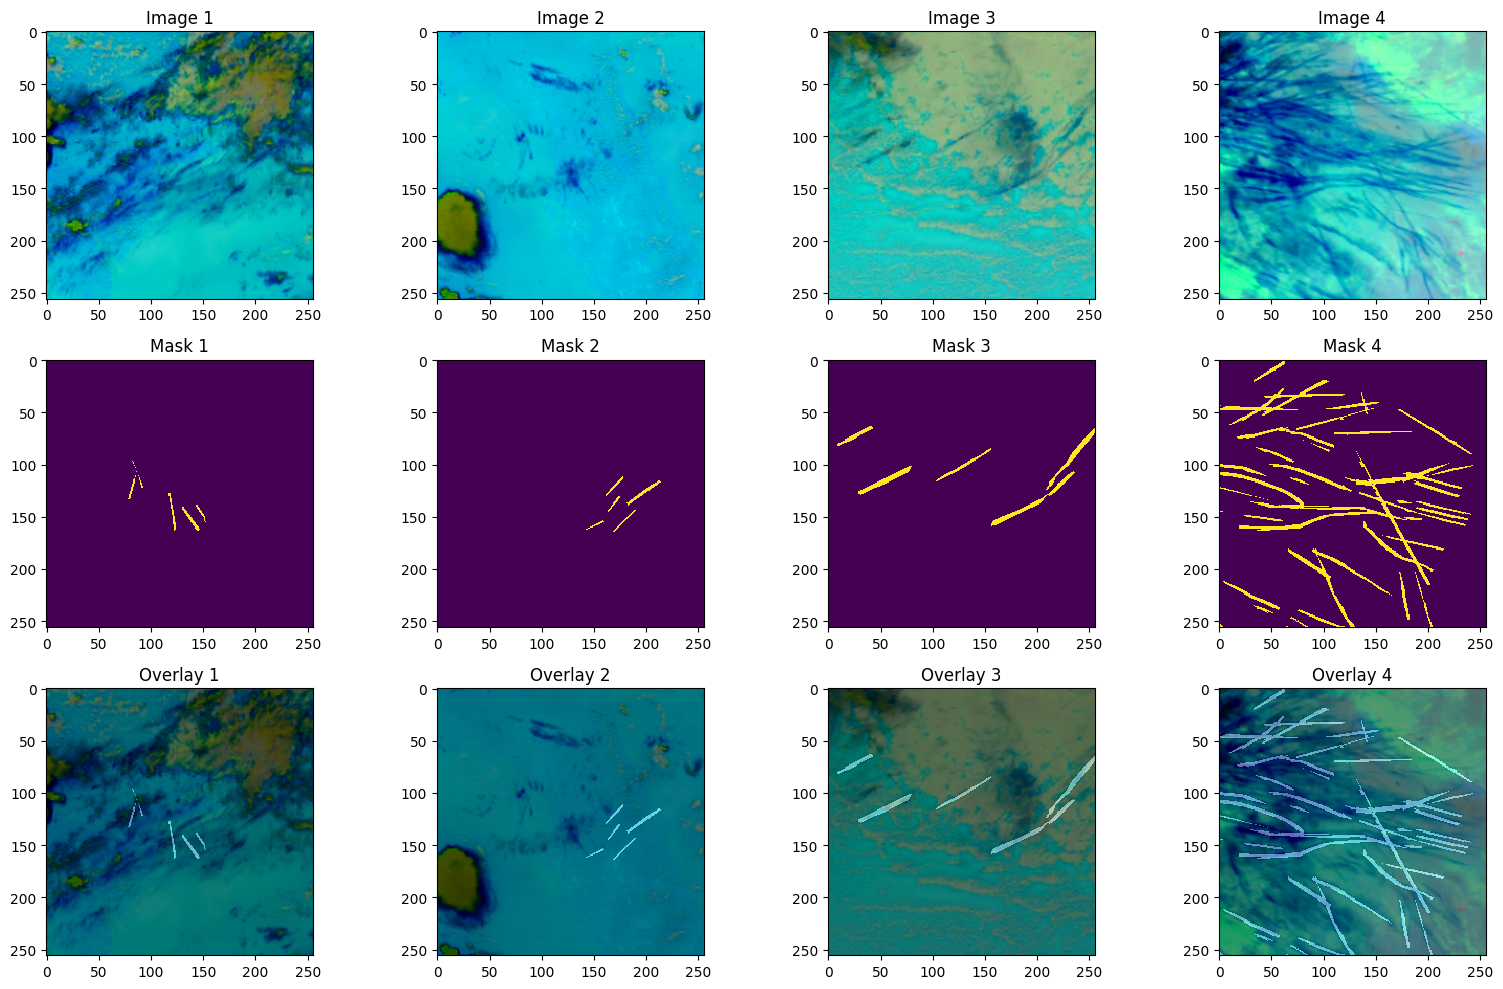

In [22]:
plot_image_and_mask_v(sf_data, sf_targets)

In [5]:
## Model Building:3DUNet++
import torch
import torch.nn as nn
import torch.nn.functional as F

class DoubleConv3D(nn.Module):
    """(Conv3D -> BN -> ReLU) * 2"""
    def __init__(self, in_channels, out_channels):
        super(DoubleConv3D, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv3d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm3d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv3d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm3d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class UNet3DPlusPlus(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, features=[64, 128, 256, 512]):
        super(UNet3DPlusPlus, self).__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        
        # Pooling layer with stride of 1 in the depth dimension to prevent collapse
        self.pool = nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(1, 2, 2), padding=(0, 0, 0))

        # Down part of U-Net++
        for feature in features:
            self.downs.append(DoubleConv3D(in_channels, feature))
            in_channels = feature

        # Up part of U-Net++
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose3d(
                    feature * 2, feature, kernel_size=2, stride=(1, 2, 2),
                )
            )
            self.ups.append(DoubleConv3D(feature * 2, feature))

        self.bottleneck = DoubleConv3D(features[-1], features[-1] * 2)
        
        # Final 2D convolution to collapse the depth dimension
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx // 2]

            if x.shape != skip_connection.shape:
                x = F.interpolate(x, size=skip_connection.shape[2:])

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx + 1](concat_skip)

        # Collapse the depth dimension and apply the final 2D convolution
        x = x.mean(dim=2)  # Average over the depth dimension
        return self.final_conv(x)

In [6]:
!ls model_checkpoints/OBJ3/3DUNetPlus_Final_v1

'epoch=14-step=61590.ckpt'  'epoch=21-step=90332.ckpt'
'epoch=18-step=78014.ckpt'  'epoch=24-step=102650.ckpt'
'epoch=19-step=82120.ckpt'   last.ckpt


In [7]:
# Load the checkpoint on the CPU
model_path = 'model_checkpoints/OBJ3/3DUNetPlus_Final_v1/'
checkpoint_path = model_path+'epoch=24-step=102650.ckpt'
checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))
saved_state_dict = checkpoint['state_dict']
prefix = "model."  # Adjust the prefix as needed
filtered_state_dict = {k[len(prefix):]: v for k, v in saved_state_dict.items() if k.startswith(prefix)}
# Load model 
mf_model =  UNet3DPlusPlus()
mf_model.load_state_dict(filtered_state_dict)
mf_model.eval()

UNet3DPlusPlus(
  (ups): ModuleList(
    (0): ConvTranspose3d(1024, 512, kernel_size=(2, 2, 2), stride=(1, 2, 2))
    (1): DoubleConv3D(
      (double_conv): Sequential(
        (0): Conv3d(1024, 512, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        (1): BatchNorm3d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv3d(512, 512, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        (4): BatchNorm3d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
    (2): ConvTranspose3d(512, 256, kernel_size=(2, 2, 2), stride=(1, 2, 2))
    (3): DoubleConv3D(
      (double_conv): Sequential(
        (0): Conv3d(512, 256, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        (1): BatchNorm3d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv3d(256, 256, kerne

In [8]:
%%time
model = mf_model.to(config.DEVICE)
data = mf_data.to(config.DEVICE)
prediction = torch.sigmoid(model(data))
prediction.shape

CPU times: user 2.25 s, sys: 1.45 s, total: 3.71 s
Wall time: 3.7 s


torch.Size([4, 1, 256, 256])

In [9]:
%%time
# Initialize lists for storing predictions and labels
all_preds = []
all_labels = []

# Inference and accuracy assessment
with torch.no_grad():
    for data, labels in iter(mf_test_dataloader):
        data = data.to(config.DEVICE)
        labels = labels.to(config.DEVICE)

        outputs = torch.sigmoid(model(data)).cpu().detach().numpy()
        # Flatten the batch dimension and append to lists
        all_preds.extend(outputs)
        all_labels.extend(labels.cpu().detach().numpy())
        
# Convert lists to numpy arrays for metric calculation
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)
all_labels.shape

CPU times: user 3min 15s, sys: 6.2 s, total: 3min 21s
Wall time: 5min 43s


(1853, 1, 256, 256)

In [13]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, jaccard_score, confusion_matrix, roc_curve, roc_auc_score
def calculate_acc_metrics(preds, labels):
    flat_preds = preds.flatten()
    flat_labels = labels.flatten()

    accuracy = accuracy_score(flat_labels, flat_preds)
    precision = precision_score(flat_labels, flat_preds, zero_division=1)
    recall = recall_score(flat_labels, flat_preds, zero_division=1)
    f1 = f1_score(flat_labels, flat_preds, zero_division=1)
    dice_score = utils.binary_iou_dice_score(torch.tensor(preds), torch.tensor(labels), metric="dice", apply_sigmoid=False)
    iou = utils.binary_iou_dice_score(torch.tensor(preds), torch.tensor(labels), metric="iou", apply_sigmoid=False)
    jac_iou = jaccard_score(flat_labels, flat_preds)

    return accuracy, precision, recall, f1, dice_score, iou, jac_iou

In [11]:
%%time
threshold = 0.4
all_preds_bin = (all_preds > threshold).astype(np.uint8)
# Prepare DataFrame for detailed results
up3d_results_df = pd.DataFrame(columns=['Image_ID', 'Accuracy', 'Precision', 'Recall', 'F1_Score',
                                   'Dice_Score' ,'IoU', 'Jacc_IoU'])

# Efficiently calculate and store metrics
results_list = []  # Initialize a list to collect results

# Iterate over predictions and labels without using tqdm
for idx, (pred, label) in enumerate(zip(all_preds_bin, all_labels)):
    acc, prec, rec, f1, dice_score, iou, jac_iou = calculate_acc_metrics(pred, label)
    results_list.append({
        'Image_ID': idx,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1_Score': f1,
        'dice_score': dice_score,
        'IoU': iou,
        'Jac_IoU': jac_iou
    })

# Convert the list of results to a DataFrame
up3d_results_df = pd.DataFrame(results_list)
up3d_results_df.head()

CPU times: user 8min 4s, sys: 3.12 s, total: 8min 7s
Wall time: 2min 27s


,Image_ID,Accuracy,Precision,Recall,F1_Score,dice_score,IoU,Jac_IoU
0,0,0.997223,0.643678,0.482759,0.551724,0.551724,0.380952,0.380952
1,1,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
2,2,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
3,3,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
4,4,0.966965,0.434721,0.908289,0.588011,0.588011,0.416442,0.416442


In [12]:
pd.options.display.float_format = '{:.2f}'.format
up3d_results_df.describe()

,Image_ID,Accuracy,Precision,Recall,F1_Score,dice_score,IoU,Jac_IoU
count,1853.00,1853.00,1853.00,1853.00,1853.00,1853.00,1853.00,1853.00
mean,926.00,1.00,0.76,0.84,0.74,0.73,0.67,0.18
std,535.06,0.01,0.31,0.27,0.33,0.34,0.36,0.24
min,0.00,0.88,0.00,0.00,0.00,0.00,0.00,0.00
25%,463.00,1.00,0.58,0.76,0.59,0.58,0.41,0.00
50%,926.00,1.00,1.00,1.00,1.00,0.87,0.77,0.00
75%,1389.00,1.00,1.00,1.00,1.00,1.00,1.00,0.42
max,1852.00,1.00,1.00,1.00,1.00,1.00,1.00,0.84


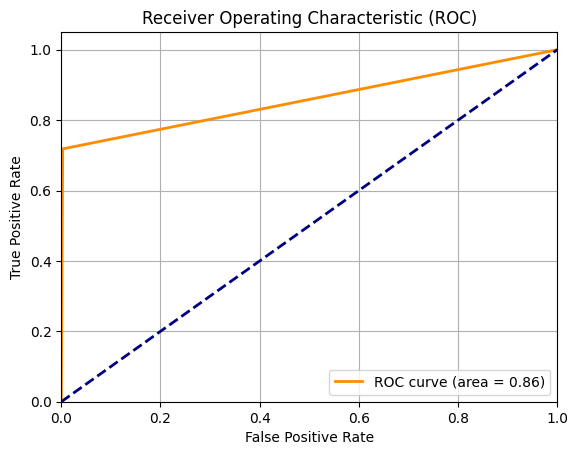

In [14]:
utils.plot_roc_auc(all_labels.flatten(), all_preds_bin.flatten())

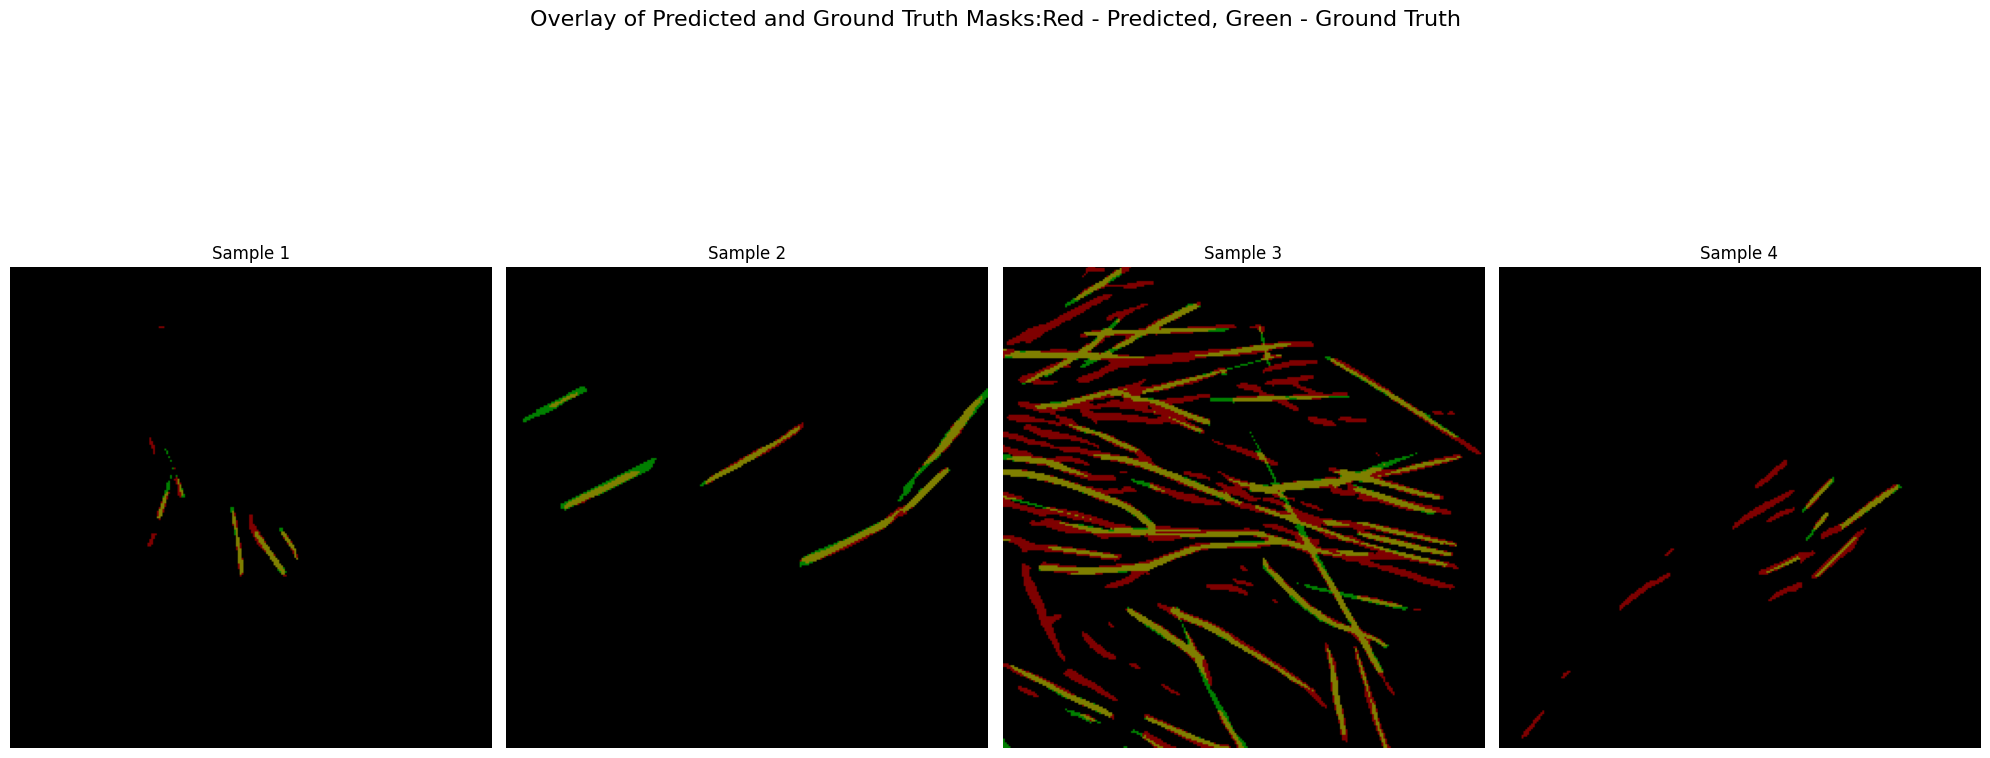

In [17]:
utils.visualize_results_with_overlay(all_preds_bin, all_labels, 4)

### Ensemble Model Result

In [8]:
## Model Building:3DUNet++
import torch
import torch.nn as nn
import torch.nn.functional as F
class EnsembleModel(nn.Module):
    def __init__(self, sf_model, mf_model):
        super(EnsembleModel, self).__init__()
        self.sf_model = sf_model  # Single Frame U-Net+ model
        self.mf_model = mf_model  # Multi-Frame 3D U-Net++ model
        
        # Assuming both models output a feature map with the same spatial dimensions
        # Define a fusion layer to combine features from both models
        self.fusion_conv = nn.Conv2d(in_channels=2, out_channels=1, kernel_size=1)

    def forward(self, x_sf, x_mf):
        # x_sf is of shape (batch_size, 5, H, W) for Single Frame model
        # x_mf is of shape (batch_size, 3, sequence_length, H, W) for Multi-Frame model

        # Extract features from the Single Frame model
        sf_features = self.sf_model(x_sf)  # (batch_size, 1, H, W)

        # Extract features from the Multi-Frame 3D U-Net++ model
        mf_features = self.mf_model(x_mf)  # (batch_size, 1, H, W)

        # Concatenate the features along the channel dimension
        combined_features = torch.cat((sf_features, mf_features), dim=1)  # (batch_size, 2, H, W)

        # Apply fusion conv layer to combine the features
        output = self.fusion_conv(combined_features)  # (batch_size, 1, H, W)

        return output

In [9]:
# Load saved model from directory
model_chkp = "model_checkpoints/OBJ2_FINAL/UNetPlus_Gauss_Tune/"
MODEL_PKL = "epoch=45-step=94438.ckpt"
model_checkpoint_path = model_chkp + MODEL_PKL
checkpoint = torch.load(model_checkpoint_path)

# Extract the state_dict from the checkpoint
saved_state_dict = checkpoint['state_dict']
prefix = "model."  # Adjust the prefix as needed
filtered_state_dict = {k[len(prefix):]: v for k, v in saved_state_dict.items() if k.startswith(prefix)}
# Load model
IN=5
FEATURE=[64, 128, 256, 512]
sf_model = UNetPlus(in_channels=IN, out_channels=1, features=FEATURE)
sf_model.load_state_dict(filtered_state_dict)
sf_model.eval()

# Create the ensemble model
checkpoint = torch.load('ensemble_model.pth')
ensemble_model = EnsembleModel(sf_model, mf_model)
#print(checkpoint.keys())
ensemble_model.load_state_dict(checkpoint)

ensemble_model.eval()

EnsembleModel(
  (sf_model): UNetPlus(
    (ups): ModuleList(
      (0): ConvTranspose2d(1024, 512, kernel_size=(2, 2), stride=(2, 2))
      (1): DoubleConv(
        (conv): Sequential(
          (0): Conv2d(1024, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Dropout2d(p=0.0, inplace=False)
          (4): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (5): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (6): ReLU(inplace=True)
          (7): Dropout2d(p=0.0, inplace=False)
        )
      )
      (2): ConvTranspose2d(512, 256, kernel_size=(2, 2), stride=(2, 2))
      (3): DoubleConv(
        (conv): Sequential(
          (0): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True,

In [10]:
%%time
ensemble_model = ensemble_model.to(config.DEVICE)

ens_all_preds = []
ens_all_labels = []

# Perform inference using the ensemble model
with torch.no_grad():
    for (sf_data_batch, mf_data_batch) in zip(sf_test_dataloader, mf_test_dataloader):
        sf_data, targets = sf_data_batch
        mf_data, _ = mf_data_batch
        sf_data = sf_data.to(config.DEVICE)
        mf_data = mf_data.to(config.DEVICE)
        labels = targets.to(config.DEVICE)
        
        ensemble_out = torch.sigmoid(ensemble_model(sf_data, mf_data)).cpu().detach().numpy()
        
        ens_all_preds.extend(ensemble_out)
        ens_all_labels.extend(labels.cpu().detach().numpy())

# Convert lists to numpy arrays for metric calculation
ens_all_preds = np.array(ens_all_preds)
ens_all_labels = np.array(ens_all_labels)
ens_all_labels.shape

CPU times: user 3min 36s, sys: 8.99 s, total: 3min 45s
Wall time: 3min 34s


(1853, 1, 256, 256)

In [14]:
%%time
threshold = 0.4
ens_all_preds_bin = (ens_all_preds > threshold).astype(np.uint8)
# Prepare DataFrame for detailed results
ens_results_df = pd.DataFrame(columns=['Image_ID', 'Accuracy', 'Precision', 'Recall', 'F1_Score',
                                   'Dice_Score' ,'IoU', 'Jacc_IoU'])

# Efficiently calculate and store metrics
results_list = []  # Initialize a list to collect results

# Iterate over predictions and labels without using tqdm
for idx, (pred, label) in enumerate(zip(ens_all_preds_bin, ens_all_labels)):
    acc, prec, rec, f1, dice_score, iou, jac_iou = calculate_acc_metrics(pred, label)
    results_list.append({
        'Image_ID': idx,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1_Score': f1,
        'dice_score': dice_score,
        'IoU': iou,
        'Jac_IoU': jac_iou
    })

# Convert the list of results to a DataFrame
ens_results_df = pd.DataFrame(results_list)
ens_results_df.head()

CPU times: user 8min 26s, sys: 2.27 s, total: 8min 28s
Wall time: 2min 23s


,Image_ID,Accuracy,Precision,Recall,F1_Score,dice_score,IoU,Jac_IoU
0,0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
1,1,1.0,1.0,1.0,1.0,1.0,1.0,0.0
2,2,1.0,1.0,1.0,1.0,1.0,1.0,0.0
3,3,1.0,1.0,1.0,1.0,1.0,1.0,0.0
4,4,1.0,1.0,1.0,1.0,1.0,1.0,0.0


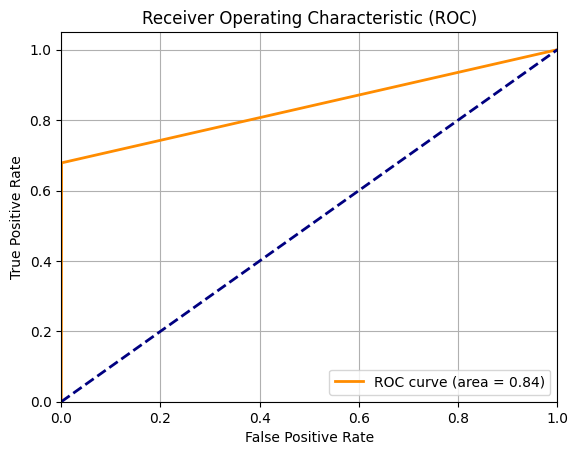

In [15]:
utils.plot_roc_auc(ens_all_labels.flatten(), ens_all_preds_bin.flatten())

In [19]:
pd.options.display.float_format = '{:.2f}'.format
ens_results_df.describe()

,Image_ID,Accuracy,Precision,Recall,F1_Score,dice_score,IoU,Jac_IoU
count,4.00,4.00,4.00,4.00,4.00,4.00,4.00,4.00
mean,1.50,0.99,0.83,0.68,0.73,0.73,0.60,0.60
std,1.29,0.02,0.08,0.24,0.19,0.19,0.22,0.22
min,0.00,0.95,0.75,0.33,0.46,0.46,0.30,0.30
25%,0.75,0.99,0.76,0.65,0.68,0.68,0.53,0.53
50%,1.50,1.00,0.83,0.76,0.79,0.79,0.66,0.66
75%,2.25,1.00,0.90,0.80,0.85,0.85,0.73,0.73
max,3.00,1.00,0.91,0.88,0.89,0.89,0.79,0.79


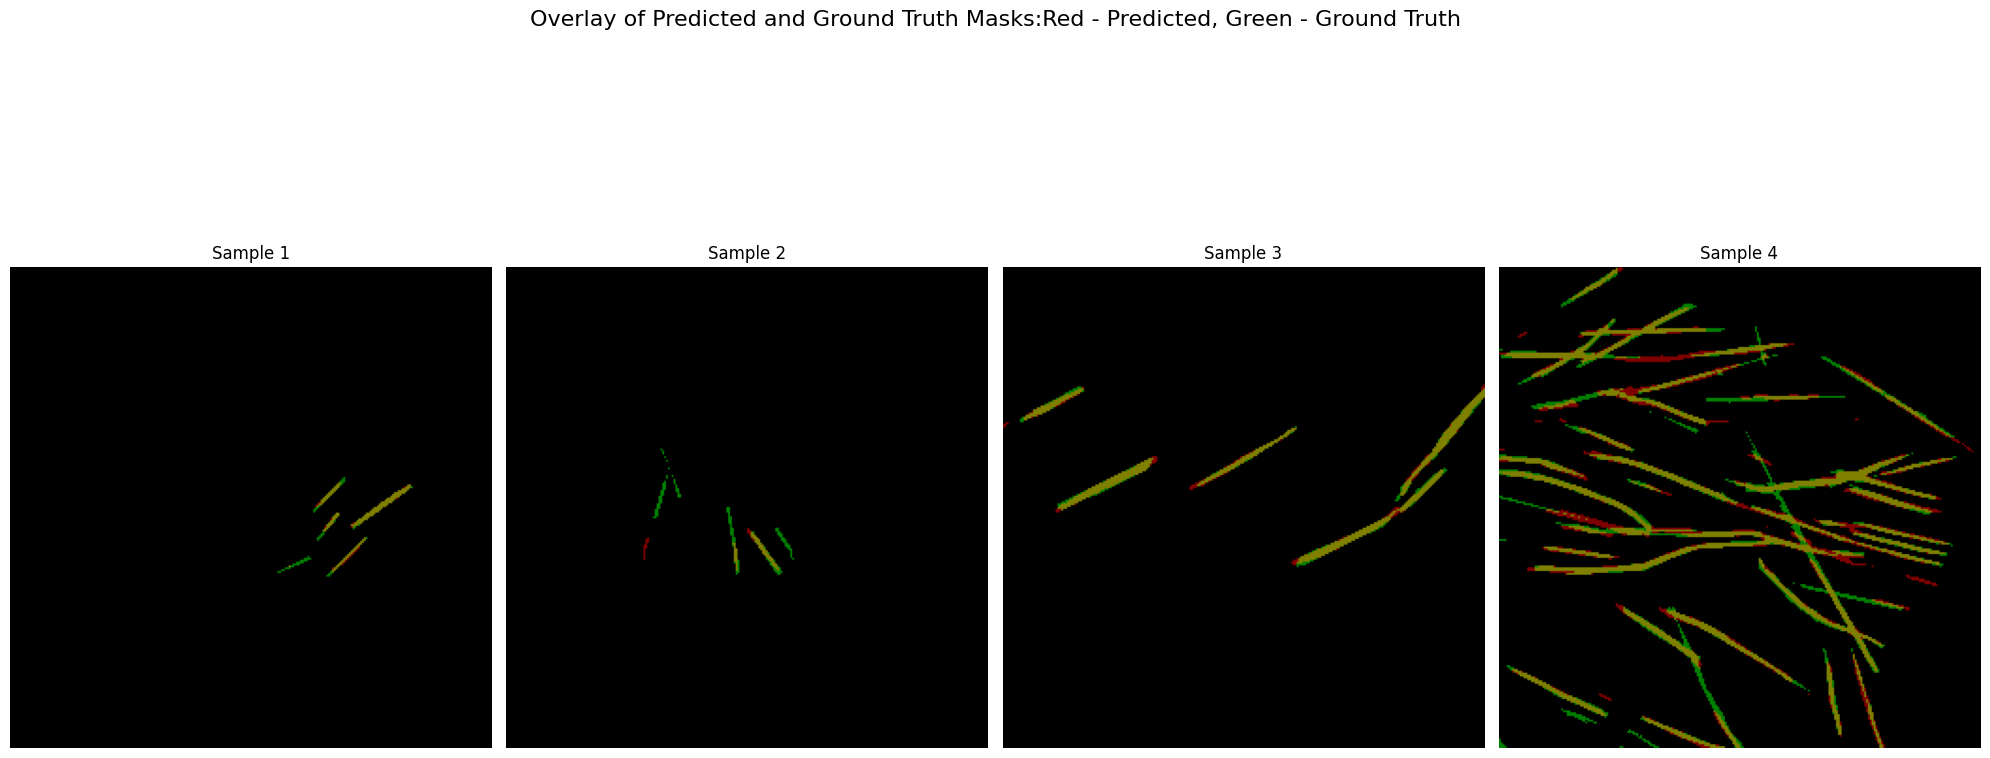

In [20]:
utils.visualize_results_with_overlay(ens_all_preds_bin, ens_all_labels, 4)

In [27]:
test_df.iloc[1800:]

,Image_ID,Class
1801,1330354743585283428,0
1802,1667997315332984272,0
1803,1323485503631672872,0
1804,1738660857358583443,0
1805,132990666217643322,0
1806,1127365700969257072,0
1807,1292768973970221654,1
1808,1653986589307358367,1
1809,1629547034361290471,0
1810,1094615407863240535,1
